In [385]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, jarque_bera, shapiro, ttest_1samp
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch, het_white
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

# Przygotowanie danych

In [386]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [387]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [388]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [389]:
pln_usd = pd.read_csv("PLNUSD=X.csv")

In [390]:
pln_usd = pln_usd[pln_usd["Close"].notnull()]

In [391]:
pln_usd.reset_index(inplace=True)

In [392]:
pln_usd["Date"] = pd.to_datetime(pln_usd["Date"])

In [393]:
dates = []
for i in range(len(pln_usd)):
    if pln_usd["Date"][i] not in list(cocoa["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(milk["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(sugar["Date"]):
        dates.append(pln_usd["Date"][i])

In [394]:
for i in range(len(cocoa)):
    if cocoa["Date"][i] not in list(pln_usd["Date"]):
        dates.append(cocoa["Date"][i])
    if sugar["Date"][i] not in list(pln_usd["Date"]):
        dates.append(sugar["Date"][i])

In [395]:
for i in range(len(milk)):
    if milk["Date"][i] not in list(pln_usd["Date"]):
        dates.append(milk["Date"][i])

In [396]:
dates = list(set(dates))

In [397]:
for i in range(len(dates)):
    pln_usd = pln_usd[pln_usd["Date"] !=  dates[i]]
    cocoa = cocoa[cocoa["Date"] !=  dates[i]]
    milk = milk[milk["Date"] !=  dates[i]]
    sugar = sugar[sugar["Date"] !=  dates[i]]

In [398]:
pln_usd = pln_usd[::-1]

In [399]:
pln_usd.reset_index(inplace=True)
cocoa.reset_index(inplace=True)
milk.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [400]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])

In [401]:
cocoa_close /= -100
milk_close /= -100
sugar_close /= -100

# 1. Estymacja średnich, odchyleń standardowych i korelacji

In [402]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

-0.0011226437699680513 0.046895540026747284
-0.0017608067092651758 0.06315052203248535
-0.0007991214057507985 0.0481337056540928


In [403]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)

In [404]:
corr = np.corrcoef(R)

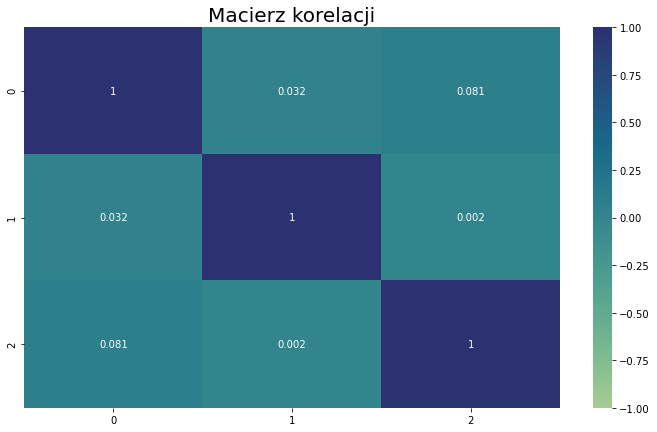

In [405]:
sns.heatmap(corr, annot=True, cmap="crest", vmin=-1, vmax=1)
plt.title("Macierz korelacji", fontsize=20)
plt.show()

## a) stopa zwrotu i ryzyko portfela z rzeczywistymi wagami 

In [406]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [407]:
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(np.mean(Rp),np.std(Rp)))

Stopa zwrotu porfela: -0.0011532196485623003, ryzyko portfela: 0.03149794745068173.


## b) możliwe portfele dla różnych wag

In [408]:
param_list = np.arange(0,1.1,0.05)

In [409]:
combinations = []
for j in range(len(param_list)-1):
    for i in range(len(param_list)-1):
        vec = np.array([param_list[j], param_list[i], round(1-param_list[i]-param_list[j],2)])
        if (vec >= 0).sum() == vec.size and (vec <= 1).sum() == vec.size:
            combinations.append(vec)


In [410]:
expected_values = []
standard_deviations = []

for comb in combinations:
    R = comb[0] * cocoa_close + comb[1] * milk_close + comb[2] * sugar_close
    expected_values.append(np.mean(R))
    standard_deviations.append(np.sqrt(np.dot(comb.T, np.dot(np.cov(R), comb))))

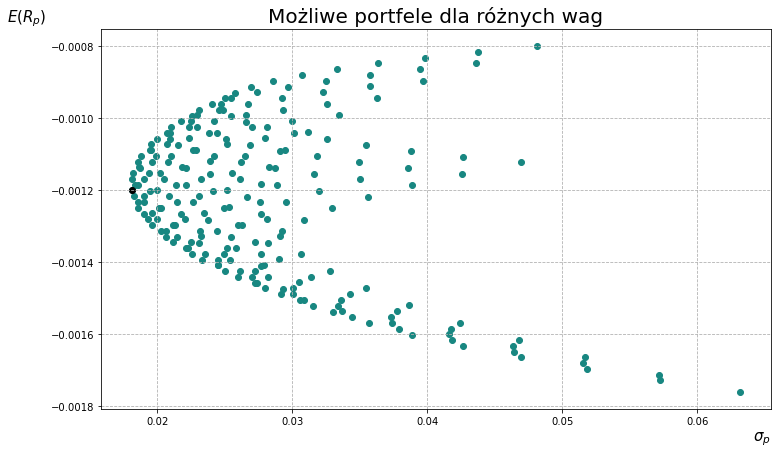

In [411]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.scatter(standard_deviations[132], expected_values[132], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## c) portfel o minimalnym ryzyku

In [412]:
standard_deviations.index(min(standard_deviations))

132

In [413]:
expected_values[132], standard_deviations[132], combinations[132]

(-0.0012008598242811506, 0.018107100110301443, array([0.35, 0.3 , 0.35]))

## d) portfel o minimalnym ryzyku przy ustalonej stopie zwrotu

In [414]:
# ustalona stopa zwrotu
r = -0.0012

In [415]:
exp = np.array(expected_values).round(5)
ind = np.where(exp == r)[0].tolist()

In [416]:
ind

[29, 85, 132, 170, 199, 219]

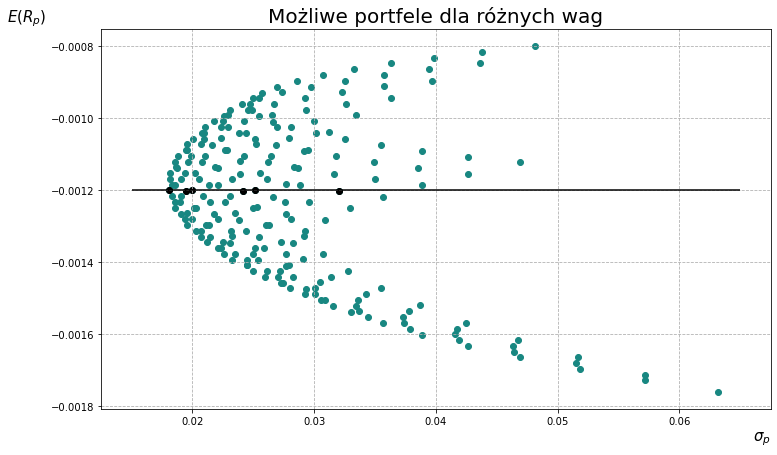

In [417]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.hlines(r, xmin=0.015, xmax=0.065, color='k')
plt.scatter([standard_deviations[i] for i in ind], [expected_values[i] for i in ind], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [418]:
b = min(expected_values, key=lambda x:abs(x-r))
expected_values.index(b)

29

In [444]:
expected_values[29], standard_deviations[29], combinations[29]

(-0.0011999716453674125, 0.02516597716697891, array([0.05, 0.4 , 0.55]))

## e) portfel rynkowy

In [420]:
x = ((np.array(expected_values) - r)/np.array(standard_deviations)).tolist()

In [421]:
x.index(max(x))

126

In [422]:
expected_values[126], standard_deviations[126], combinations[126]

(-0.0009123542332268375, 0.026943458369885567, array([0.35, 0.  , 0.65]))

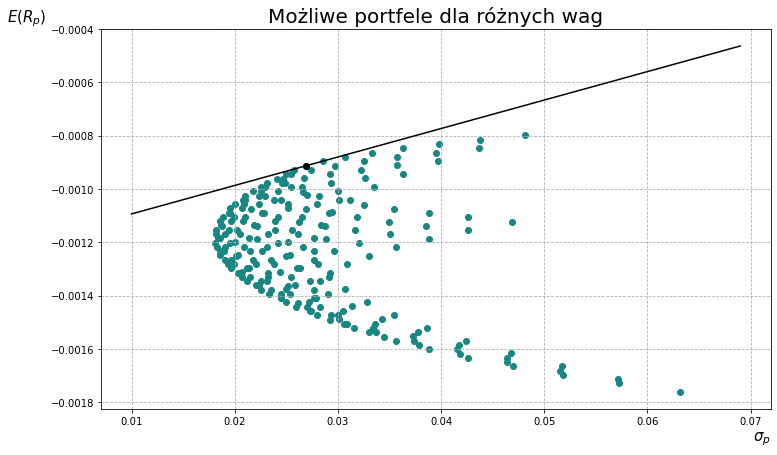

In [423]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.plot(np.arange(0.01,0.07,0.001), np.arange(0.01,0.07,0.001) * max(x) + r, color='k')
plt.scatter(standard_deviations[126], expected_values[126], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

# Model jednowskaźnikowy

## Kakao

In [424]:
pln_usd['MonthlyAverage'] = (pln_usd.groupby(pln_usd['Date'].dt.to_period('M'))
                          ['Close'].transform('mean')
                       )

In [425]:
pln_usd_close = pln_usd['Close']/pln_usd['MonthlyAverage']

In [426]:
cocoa['MonthlyAverage'] = (cocoa.groupby(cocoa['Date'].dt.to_period('M'))
                          ['Close/Last'].transform('mean'))

In [427]:
cocoa_close = cocoa['Close/Last']/cocoa['MonthlyAverage']

In [428]:
# cocoa_close2 = np.array([round((cocoa_close[i] - cocoa_close[i+1])/(cocoa_close[i+1] * T),3) for i in range(len(cocoa_close)-1)])
# pln_usd_close2 = np.array([round((pln_usd_close[i] - pln_usd_close[i+1])/(pln_usd_close[i+1] * T),3) for i in range(len(pln_usd_close)-1)])

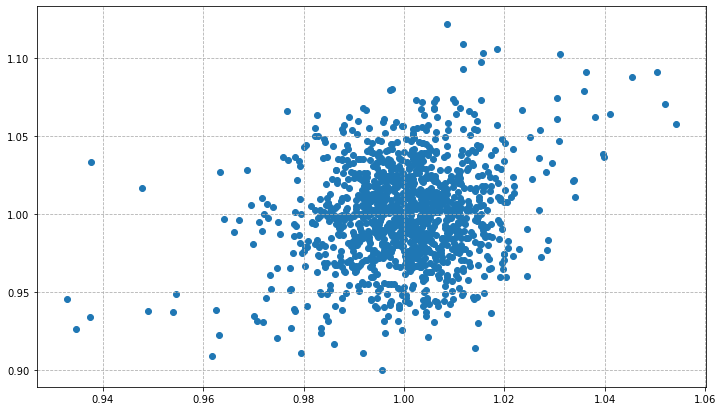

In [429]:
plt.scatter(pln_usd_close,cocoa_close)
plt.show()

In [430]:
y = cocoa_close
x = pln_usd_close

In [431]:
x = sm.add_constant(x)

In [432]:
model = sm.GLS(y, x).fit()

In [433]:
print(model.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            GLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     64.55
Date:                Sat, 07 May 2022   Prob (F-statistic):           2.16e-15
Time:                        14:37:48   Log-Likelihood:                 2566.9
No. Observations:                1253   AIC:                            -5130.
Df Residuals:                    1251   BIC:                            -5120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4289      0.071      6.033      0.0

In [434]:
alpha = model.params['const']
beta = model.params[0]

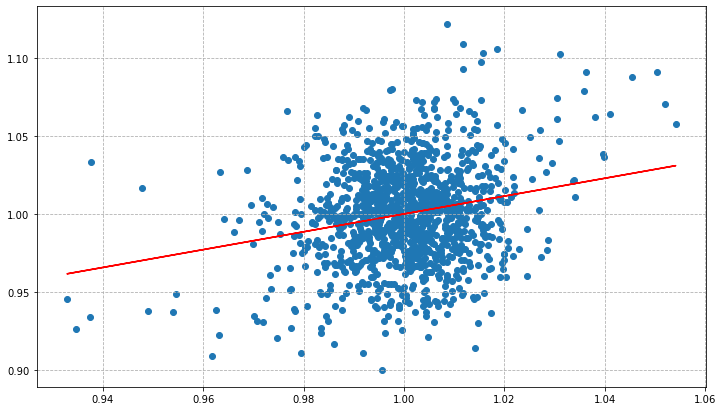

In [435]:
plt.scatter(pln_usd_close,cocoa_close)
plt.plot(pln_usd_close,pln_usd_close*beta + alpha,color='red')
plt.show()

In [436]:
epsilon = model.resid

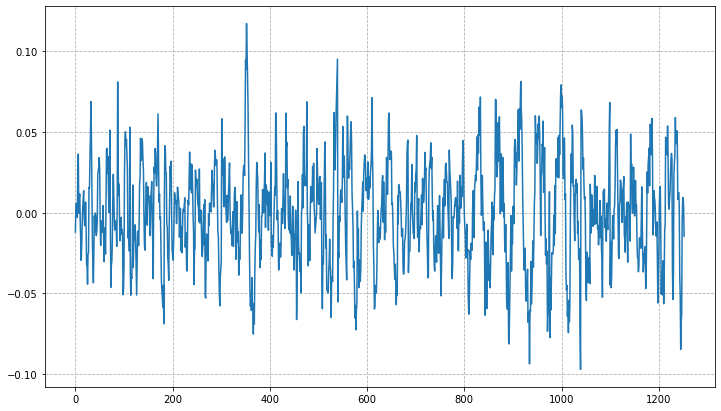

In [437]:
plt.plot(epsilon)
plt.show()

In [438]:
het_arch(epsilon)

(508.8641301161321,
 5.043865963088955e-93,
 37.000211963245306,
 2.082943740193539e-122)

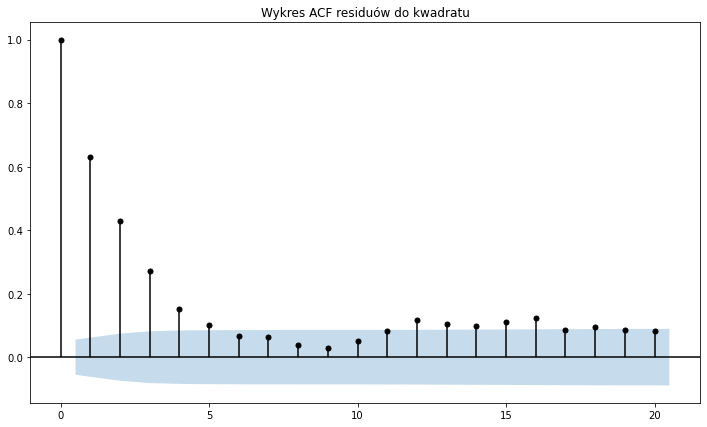

In [439]:
plot_acf(np.array(epsilon)**2, lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów do kwadratu")
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [440]:
acorr_ljungbox(epsilon,lags=[30],return_df=True)

,lb_stat,lb_pvalue
30,2715.195013,0.0


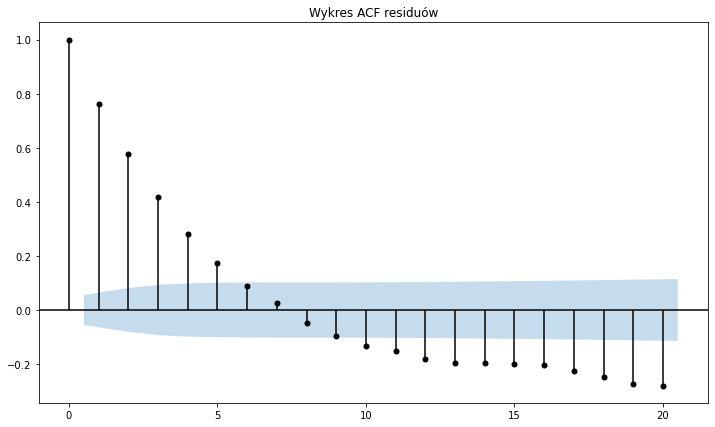

In [441]:
plot_acf(np.array(epsilon), lags=20, color="k", vlines_kwargs={"colors": "k"}, title="Wykres ACF residuów")
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [442]:
print("Test Kołmogorowa-Smirnowa: {}.".format(kstest( (epsilon-epsilon.mean())/epsilon.std() , 'norm').pvalue))
print("Test Jarque-Bera: {}.".format(jarque_bera(epsilon).pvalue))
print("Test Shapiro-Wilka: {}.".format(shapiro(epsilon).pvalue))

Test Kołmogorowa-Smirnowa: 0.9581850818127976.
Test Jarque-Bera: 0.4962909699053393.
Test Shapiro-Wilka: 0.7060420513153076.


In [443]:
ttest_1samp(epsilon, 0)

Ttest_1sampResult(statistic=1.057330659298854e-12, pvalue=0.9999999999991566)

## Mleko